# Variational Auto-Encoder

In [2]:
# add necessary toolbox

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)),interpolation='nearest')
    
def plot_reconstruction(model, n=24):
    x,_ = next(iter(data_loader))
    x = x[:n,:,:,:].to(device)
    try:
        out, _, _, log_p = model(x.view(-1, image_size)) 
    except:
        out, _, _ = model(x.view(-1, image_size)) 
    x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
    out_grid = torchvision.utils.make_grid(x_concat).cpu().data
    show(out_grid)
    
def plot_generation(model, n=24):
    with torch.no_grad():
        z = torch.randn(n, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

def plot_conditional_generation(model, n=8, fix_number=None):
    with torch.no_grad():
        matrix = np.zeros((n,n_classes))
        matrix[:,0] = 1

        if fix_number is None:
            final = matrix[:]
            for i in range(1,n_classes):
                final = np.vstack((final,np.roll(matrix,i)))
            #z = torch.randn(8*n_classes, z_dim).to(device)
            z = torch.randn(8, z_dim)
            z = z.repeat(n_classes,1).to(device)
            y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)
        else:
            z = torch.randn(n, z_dim).to(device)
            y_onehot = torch.tensor(np.roll(matrix, fix_number)).type(torch.FloatTensor).to(device)
            out = model.decode(z,y_onehot).view(-1, 1, 28, 28)

    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [4]:
data_dir = 'data'

# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=128, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

we will implement the simplest VAE architecture as in figure below

![vae.png](vae.png)

In [5]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence between Gaussians, see Appendix B in VAE paper or (Doersch, 2016):
        # https://arxiv.org/abs/1606.05908
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x), kl_div.item()/len(x)))

Epoch[1/15], Step [10/469], Reconst Loss: 285.5026, KL Div: 23.2383
Epoch[1/15], Step [20/469], Reconst Loss: 233.2834, KL Div: 9.1144
Epoch[1/15], Step [30/469], Reconst Loss: 216.9951, KL Div: 10.5662
Epoch[1/15], Step [40/469], Reconst Loss: 205.2334, KL Div: 5.4127
Epoch[1/15], Step [50/469], Reconst Loss: 205.1471, KL Div: 5.1288
Epoch[1/15], Step [60/469], Reconst Loss: 193.4752, KL Div: 7.0826
Epoch[1/15], Step [70/469], Reconst Loss: 192.2245, KL Div: 8.4842
Epoch[1/15], Step [80/469], Reconst Loss: 188.4784, KL Div: 7.8272
Epoch[1/15], Step [90/469], Reconst Loss: 183.2603, KL Div: 9.4807
Epoch[1/15], Step [100/469], Reconst Loss: 165.2346, KL Div: 11.2966
Epoch[1/15], Step [110/469], Reconst Loss: 168.9417, KL Div: 12.7244
Epoch[1/15], Step [120/469], Reconst Loss: 152.0999, KL Div: 13.2472
Epoch[1/15], Step [130/469], Reconst Loss: 154.8014, KL Div: 13.2840
Epoch[1/15], Step [140/469], Reconst Loss: 158.3083, KL Div: 13.8396
Epoch[1/15], Step [150/469], Reconst Loss: 144.052

Epoch[3/15], Step [300/469], Reconst Loss: 90.2275, KL Div: 24.4408
Epoch[3/15], Step [310/469], Reconst Loss: 93.3972, KL Div: 24.3507
Epoch[3/15], Step [320/469], Reconst Loss: 90.5472, KL Div: 25.0783
Epoch[3/15], Step [330/469], Reconst Loss: 92.8574, KL Div: 23.1281
Epoch[3/15], Step [340/469], Reconst Loss: 91.3431, KL Div: 24.5659
Epoch[3/15], Step [350/469], Reconst Loss: 88.0520, KL Div: 23.7657
Epoch[3/15], Step [360/469], Reconst Loss: 89.0582, KL Div: 23.4651
Epoch[3/15], Step [370/469], Reconst Loss: 92.3850, KL Div: 24.0401
Epoch[3/15], Step [380/469], Reconst Loss: 88.0340, KL Div: 23.7384
Epoch[3/15], Step [390/469], Reconst Loss: 89.4086, KL Div: 23.8330
Epoch[3/15], Step [400/469], Reconst Loss: 90.4244, KL Div: 24.4544
Epoch[3/15], Step [410/469], Reconst Loss: 88.0349, KL Div: 24.1818
Epoch[3/15], Step [420/469], Reconst Loss: 90.7538, KL Div: 24.2662
Epoch[3/15], Step [430/469], Reconst Loss: 89.9523, KL Div: 24.3035
Epoch[3/15], Step [440/469], Reconst Loss: 91.97

Epoch[6/15], Step [130/469], Reconst Loss: 83.0759, KL Div: 25.4614
Epoch[6/15], Step [140/469], Reconst Loss: 83.3126, KL Div: 25.0215
Epoch[6/15], Step [150/469], Reconst Loss: 86.3298, KL Div: 26.0707
Epoch[6/15], Step [160/469], Reconst Loss: 83.6253, KL Div: 24.5455
Epoch[6/15], Step [170/469], Reconst Loss: 84.2390, KL Div: 24.8512
Epoch[6/15], Step [180/469], Reconst Loss: 80.4794, KL Div: 24.9252
Epoch[6/15], Step [190/469], Reconst Loss: 81.8589, KL Div: 24.6201
Epoch[6/15], Step [200/469], Reconst Loss: 84.0386, KL Div: 25.0312
Epoch[6/15], Step [210/469], Reconst Loss: 90.3098, KL Div: 25.3122
Epoch[6/15], Step [220/469], Reconst Loss: 85.2469, KL Div: 25.5269
Epoch[6/15], Step [230/469], Reconst Loss: 88.0094, KL Div: 24.6458
Epoch[6/15], Step [240/469], Reconst Loss: 82.2641, KL Div: 25.2704
Epoch[6/15], Step [250/469], Reconst Loss: 83.8559, KL Div: 24.5869
Epoch[6/15], Step [260/469], Reconst Loss: 81.0838, KL Div: 24.3077
Epoch[6/15], Step [270/469], Reconst Loss: 86.11

Epoch[8/15], Step [420/469], Reconst Loss: 81.3713, KL Div: 24.5130
Epoch[8/15], Step [430/469], Reconst Loss: 78.6739, KL Div: 25.2154
Epoch[8/15], Step [440/469], Reconst Loss: 85.2559, KL Div: 24.7933
Epoch[8/15], Step [450/469], Reconst Loss: 83.4007, KL Div: 25.9318
Epoch[8/15], Step [460/469], Reconst Loss: 77.3684, KL Div: 24.9392
Epoch[9/15], Step [10/469], Reconst Loss: 84.5972, KL Div: 25.7416
Epoch[9/15], Step [20/469], Reconst Loss: 79.8368, KL Div: 25.1351
Epoch[9/15], Step [30/469], Reconst Loss: 81.4567, KL Div: 25.1987
Epoch[9/15], Step [40/469], Reconst Loss: 81.0725, KL Div: 25.4362
Epoch[9/15], Step [50/469], Reconst Loss: 79.9975, KL Div: 24.7400
Epoch[9/15], Step [60/469], Reconst Loss: 79.4808, KL Div: 25.1568
Epoch[9/15], Step [70/469], Reconst Loss: 84.9749, KL Div: 25.5781
Epoch[9/15], Step [80/469], Reconst Loss: 78.5859, KL Div: 24.2397
Epoch[9/15], Step [90/469], Reconst Loss: 81.5206, KL Div: 24.8134
Epoch[9/15], Step [100/469], Reconst Loss: 82.9951, KL Di

Epoch[11/15], Step [240/469], Reconst Loss: 74.9120, KL Div: 23.8172
Epoch[11/15], Step [250/469], Reconst Loss: 83.3215, KL Div: 25.6164
Epoch[11/15], Step [260/469], Reconst Loss: 82.4740, KL Div: 25.5642
Epoch[11/15], Step [270/469], Reconst Loss: 78.2574, KL Div: 25.3655
Epoch[11/15], Step [280/469], Reconst Loss: 83.4501, KL Div: 24.6111
Epoch[11/15], Step [290/469], Reconst Loss: 78.7964, KL Div: 25.9080
Epoch[11/15], Step [300/469], Reconst Loss: 79.5127, KL Div: 25.3498
Epoch[11/15], Step [310/469], Reconst Loss: 78.7027, KL Div: 25.1354
Epoch[11/15], Step [320/469], Reconst Loss: 78.8835, KL Div: 24.7090
Epoch[11/15], Step [330/469], Reconst Loss: 80.1704, KL Div: 25.7730
Epoch[11/15], Step [340/469], Reconst Loss: 82.4649, KL Div: 25.3642
Epoch[11/15], Step [350/469], Reconst Loss: 80.4485, KL Div: 25.4841
Epoch[11/15], Step [360/469], Reconst Loss: 80.5066, KL Div: 25.6605
Epoch[11/15], Step [370/469], Reconst Loss: 79.6849, KL Div: 25.1666
Epoch[11/15], Step [380/469], Reco

Epoch[14/15], Step [60/469], Reconst Loss: 81.1209, KL Div: 25.4387
Epoch[14/15], Step [70/469], Reconst Loss: 80.3649, KL Div: 25.9991
Epoch[14/15], Step [80/469], Reconst Loss: 78.0762, KL Div: 24.3355
Epoch[14/15], Step [90/469], Reconst Loss: 78.3180, KL Div: 25.0028
Epoch[14/15], Step [100/469], Reconst Loss: 79.5035, KL Div: 25.8306
Epoch[14/15], Step [110/469], Reconst Loss: 79.0994, KL Div: 24.5917
Epoch[14/15], Step [120/469], Reconst Loss: 77.1844, KL Div: 24.6368
Epoch[14/15], Step [130/469], Reconst Loss: 79.0466, KL Div: 25.6152
Epoch[14/15], Step [140/469], Reconst Loss: 78.9283, KL Div: 24.6290
Epoch[14/15], Step [150/469], Reconst Loss: 77.7815, KL Div: 24.6119
Epoch[14/15], Step [160/469], Reconst Loss: 77.8664, KL Div: 25.0383
Epoch[14/15], Step [170/469], Reconst Loss: 79.9813, KL Div: 25.0458
Epoch[14/15], Step [180/469], Reconst Loss: 79.4469, KL Div: 25.7462
Epoch[14/15], Step [190/469], Reconst Loss: 76.4060, KL Div: 24.2115
Epoch[14/15], Step [200/469], Reconst 

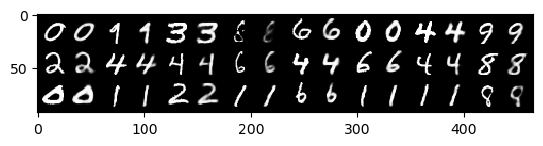

In [9]:
plot_reconstruction(model)

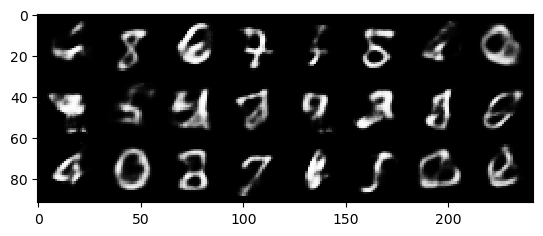

In [10]:
plot_generation(model)

# Conditional Variational Auto-Encoder

In [79]:
# function transforming a label in its onehot encoding

n_classes = 10
def l_2_onehot(labels,nb_digits=n_classes):
    # take labels (from the dataloader) and return labels onehot-encoded
    
    n_labels = len(labels)
    onehots = np.zeros((n_labels,nb_digits))
    for idx in range(n_labels):
        onehots[idx,labels[idx]] = 1.0
        
    return torch.tensor(onehots)

In [80]:
(x,labels) = next(iter(data_loader))

In [81]:
labels

tensor([2, 9, 5, 8, 7, 5, 8, 4, 8, 0, 1, 7, 9, 1, 4, 4, 8, 9, 4, 2, 4, 0, 0, 8,
        6, 5, 5, 8, 3, 8, 3, 9, 6, 6, 1, 9, 3, 8, 5, 1, 0, 6, 8, 1, 6, 4, 0, 0,
        6, 5, 0, 1, 1, 2, 0, 2, 0, 0, 8, 6, 7, 6, 0, 3, 8, 5, 0, 3, 1, 5, 9, 4,
        4, 7, 2, 8, 0, 7, 6, 2, 7, 3, 5, 4, 6, 0, 0, 2, 4, 6, 1, 5, 5, 2, 4, 1,
        0, 0, 6, 9, 9, 1, 8, 3, 5, 4, 2, 9, 8, 0, 9, 0, 7, 5, 3, 0, 0, 3, 5, 7,
        2, 0, 3, 2, 0, 4, 1, 9])

In [82]:
l_2_onehot(labels)

tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [104]:
# modify VAE architecture where decoder takes as input random code concatenated with the one-hot encoding of label

n_classes = 10

class VAE_Cond(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Cond, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        
        z_dim_new = z_dim + n_classes
        self.fc4 = nn.Linear(z_dim_new, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, l_onehot):
        temp = torch.cat([z,l_onehot],1)
        h = F.relu(self.fc4(temp.float()))
        return torch.sigmoid(self.fc5(h))     
    
    def forward(self, x, l_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z,l_onehot)
        return x_reconst, mu, log_var        

In [105]:
model_C = VAE_Cond().to(device)
x = x.to(device).view(-1, image_size)
l_onehot = l_2_onehot(labels)
l_onehot = l_onehot.to(device)
model_C(x, l_onehot)

(tensor([[0.4714, 0.4437, 0.4958,  ..., 0.4447, 0.4335, 0.5673],
         [0.4888, 0.4869, 0.5627,  ..., 0.5097, 0.5390, 0.4804],
         [0.5348, 0.5487, 0.5320,  ..., 0.4172, 0.4749, 0.5708],
         ...,
         [0.5247, 0.4987, 0.5553,  ..., 0.5107, 0.5053, 0.6031],
         [0.5062, 0.4992, 0.5238,  ..., 0.4650, 0.5096, 0.5525],
         [0.5277, 0.4482, 0.5572,  ..., 0.4973, 0.5255, 0.5497]],
        grad_fn=<SigmoidBackward0>),
 tensor([[-0.0293,  0.1520, -0.0777,  ..., -0.0434,  0.0627, -0.0174],
         [ 0.0115,  0.1245, -0.0455,  ..., -0.0602,  0.0952, -0.1512],
         [ 0.0447, -0.0090,  0.0161,  ...,  0.0293,  0.1156, -0.0532],
         ...,
         [ 0.1019,  0.0335, -0.1068,  ..., -0.0918,  0.0263, -0.1007],
         [ 0.0517,  0.0204, -0.0652,  ..., -0.0133, -0.0116, -0.0190],
         [ 0.0592, -0.0361, -0.0154,  ..., -0.0344,  0.0194, -0.0329]],
        grad_fn=<AddmmBackward0>),
 tensor([[ 0.1098,  0.1083, -0.0048,  ...,  0.0190, -0.0016, -0.0290],
         [ 

In [106]:
def train_C(model, data_loader=data_loader,num_epochs=num_epochs, beta=10., verbose=True):
    nmi_scores = []
    model.train(True)
    for epoch in range(num_epochs):
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            l_onehot = l_2_onehot(labels)
            l_onehot = l_onehot.to(device)
            x_reconst, mu, log_var = model_C(x, l_onehot)
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div =  - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            
            # Backprop and optimize
            loss = reconst_loss + beta*kl_div
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}"
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/len(x),
                                   kl_div.item()/len(x)))

In [107]:
model_C = VAE_Cond().to(device)
optimizer = torch.optim.Adam(model_C.parameters(), lr=learning_rate)

In [108]:
train_C(model_C,num_epochs=15,verbose=True)

Epoch[1/15], Step [10/469], Reconst Loss: 343.7117, KL Div: 2.0275
Epoch[1/15], Step [20/469], Reconst Loss: 246.7632, KL Div: 1.6164
Epoch[1/15], Step [30/469], Reconst Loss: 229.6676, KL Div: 0.6568
Epoch[1/15], Step [40/469], Reconst Loss: 208.3827, KL Div: 0.4390
Epoch[1/15], Step [50/469], Reconst Loss: 215.6420, KL Div: 0.2943
Epoch[1/15], Step [60/469], Reconst Loss: 205.4675, KL Div: 0.2968
Epoch[1/15], Step [70/469], Reconst Loss: 208.2033, KL Div: 0.2252
Epoch[1/15], Step [80/469], Reconst Loss: 203.0529, KL Div: 0.2854
Epoch[1/15], Step [90/469], Reconst Loss: 196.7272, KL Div: 0.3148
Epoch[1/15], Step [100/469], Reconst Loss: 195.3306, KL Div: 0.2969
Epoch[1/15], Step [110/469], Reconst Loss: 199.5014, KL Div: 0.2913
Epoch[1/15], Step [120/469], Reconst Loss: 185.9654, KL Div: 0.3614
Epoch[1/15], Step [130/469], Reconst Loss: 194.3065, KL Div: 0.3491
Epoch[1/15], Step [140/469], Reconst Loss: 183.8534, KL Div: 0.3567
Epoch[1/15], Step [150/469], Reconst Loss: 192.5878, KL D

Epoch[3/15], Step [310/469], Reconst Loss: 163.0602, KL Div: 1.0315
Epoch[3/15], Step [320/469], Reconst Loss: 158.2005, KL Div: 0.9820
Epoch[3/15], Step [330/469], Reconst Loss: 159.9274, KL Div: 0.9333
Epoch[3/15], Step [340/469], Reconst Loss: 163.5813, KL Div: 1.1541
Epoch[3/15], Step [350/469], Reconst Loss: 160.4998, KL Div: 1.0801
Epoch[3/15], Step [360/469], Reconst Loss: 160.7247, KL Div: 1.1810
Epoch[3/15], Step [370/469], Reconst Loss: 154.5107, KL Div: 1.1080
Epoch[3/15], Step [380/469], Reconst Loss: 152.2032, KL Div: 1.1022
Epoch[3/15], Step [390/469], Reconst Loss: 154.9726, KL Div: 1.0774
Epoch[3/15], Step [400/469], Reconst Loss: 151.7148, KL Div: 1.0079
Epoch[3/15], Step [410/469], Reconst Loss: 147.8441, KL Div: 1.0184
Epoch[3/15], Step [420/469], Reconst Loss: 148.9253, KL Div: 0.9942
Epoch[3/15], Step [430/469], Reconst Loss: 150.0276, KL Div: 0.9502
Epoch[3/15], Step [440/469], Reconst Loss: 156.8006, KL Div: 1.1536
Epoch[3/15], Step [450/469], Reconst Loss: 157.8

Epoch[6/15], Step [140/469], Reconst Loss: 145.1380, KL Div: 1.3954
Epoch[6/15], Step [150/469], Reconst Loss: 147.9499, KL Div: 1.3995
Epoch[6/15], Step [160/469], Reconst Loss: 143.5287, KL Div: 1.3092
Epoch[6/15], Step [170/469], Reconst Loss: 142.4420, KL Div: 1.3109
Epoch[6/15], Step [180/469], Reconst Loss: 145.8750, KL Div: 1.3148
Epoch[6/15], Step [190/469], Reconst Loss: 147.3972, KL Div: 1.4738
Epoch[6/15], Step [200/469], Reconst Loss: 147.2677, KL Div: 1.3443
Epoch[6/15], Step [210/469], Reconst Loss: 151.6708, KL Div: 1.2422
Epoch[6/15], Step [220/469], Reconst Loss: 148.4090, KL Div: 1.3192
Epoch[6/15], Step [230/469], Reconst Loss: 139.0885, KL Div: 1.3493
Epoch[6/15], Step [240/469], Reconst Loss: 151.5327, KL Div: 1.3114
Epoch[6/15], Step [250/469], Reconst Loss: 147.2316, KL Div: 1.3700
Epoch[6/15], Step [260/469], Reconst Loss: 147.3792, KL Div: 1.3213
Epoch[6/15], Step [270/469], Reconst Loss: 144.2801, KL Div: 1.4215
Epoch[6/15], Step [280/469], Reconst Loss: 148.1

Epoch[8/15], Step [430/469], Reconst Loss: 145.6089, KL Div: 1.4656
Epoch[8/15], Step [440/469], Reconst Loss: 144.3653, KL Div: 1.5624
Epoch[8/15], Step [450/469], Reconst Loss: 141.8630, KL Div: 1.5085
Epoch[8/15], Step [460/469], Reconst Loss: 137.4536, KL Div: 1.4966
Epoch[9/15], Step [10/469], Reconst Loss: 144.7346, KL Div: 1.5611
Epoch[9/15], Step [20/469], Reconst Loss: 145.7412, KL Div: 1.4304
Epoch[9/15], Step [30/469], Reconst Loss: 145.1987, KL Div: 1.5962
Epoch[9/15], Step [40/469], Reconst Loss: 143.9950, KL Div: 1.6001
Epoch[9/15], Step [50/469], Reconst Loss: 152.3615, KL Div: 1.7105
Epoch[9/15], Step [60/469], Reconst Loss: 150.3885, KL Div: 1.5357
Epoch[9/15], Step [70/469], Reconst Loss: 146.0077, KL Div: 1.7095
Epoch[9/15], Step [80/469], Reconst Loss: 149.1304, KL Div: 1.6299
Epoch[9/15], Step [90/469], Reconst Loss: 134.9939, KL Div: 1.5161
Epoch[9/15], Step [100/469], Reconst Loss: 145.6379, KL Div: 1.5248
Epoch[9/15], Step [110/469], Reconst Loss: 150.1712, KL D

Epoch[11/15], Step [250/469], Reconst Loss: 144.4969, KL Div: 1.6329
Epoch[11/15], Step [260/469], Reconst Loss: 139.3585, KL Div: 1.7273
Epoch[11/15], Step [270/469], Reconst Loss: 138.8372, KL Div: 1.7152
Epoch[11/15], Step [280/469], Reconst Loss: 147.2595, KL Div: 1.7260
Epoch[11/15], Step [290/469], Reconst Loss: 141.5281, KL Div: 1.5348
Epoch[11/15], Step [300/469], Reconst Loss: 146.5184, KL Div: 1.8328
Epoch[11/15], Step [310/469], Reconst Loss: 135.5536, KL Div: 1.5268
Epoch[11/15], Step [320/469], Reconst Loss: 142.3897, KL Div: 1.6022
Epoch[11/15], Step [330/469], Reconst Loss: 150.3326, KL Div: 1.7373
Epoch[11/15], Step [340/469], Reconst Loss: 145.7004, KL Div: 1.6405
Epoch[11/15], Step [350/469], Reconst Loss: 143.3695, KL Div: 1.7504
Epoch[11/15], Step [360/469], Reconst Loss: 140.9140, KL Div: 1.6782
Epoch[11/15], Step [370/469], Reconst Loss: 145.8853, KL Div: 1.5195
Epoch[11/15], Step [380/469], Reconst Loss: 144.2832, KL Div: 1.5964
Epoch[11/15], Step [390/469], Reco

Epoch[14/15], Step [80/469], Reconst Loss: 141.8414, KL Div: 1.7963
Epoch[14/15], Step [90/469], Reconst Loss: 139.5235, KL Div: 1.7062
Epoch[14/15], Step [100/469], Reconst Loss: 141.1952, KL Div: 1.6939
Epoch[14/15], Step [110/469], Reconst Loss: 140.7431, KL Div: 1.7602
Epoch[14/15], Step [120/469], Reconst Loss: 138.4671, KL Div: 1.6847
Epoch[14/15], Step [130/469], Reconst Loss: 145.2654, KL Div: 1.5936
Epoch[14/15], Step [140/469], Reconst Loss: 142.5785, KL Div: 1.7882
Epoch[14/15], Step [150/469], Reconst Loss: 139.6973, KL Div: 1.7021
Epoch[14/15], Step [160/469], Reconst Loss: 133.1683, KL Div: 1.7544
Epoch[14/15], Step [170/469], Reconst Loss: 141.9736, KL Div: 1.6859
Epoch[14/15], Step [180/469], Reconst Loss: 133.6217, KL Div: 1.7408
Epoch[14/15], Step [190/469], Reconst Loss: 149.3855, KL Div: 1.8131
Epoch[14/15], Step [200/469], Reconst Loss: 137.1578, KL Div: 1.7780
Epoch[14/15], Step [210/469], Reconst Loss: 137.5143, KL Div: 1.6872
Epoch[14/15], Step [220/469], Recons

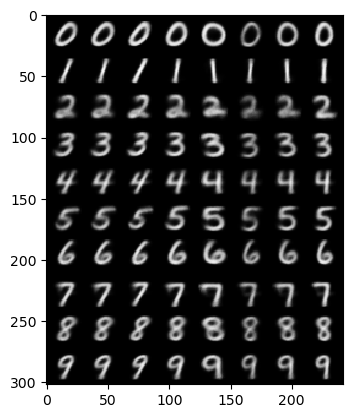

In [109]:
plot_conditional_generation(model_C, n=8)